Part2 - Stanford Dog Breed Classification

Reporting To: Dr. Alex Vakanski

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Introduction

In this notebook we will be learning how to do 4 tasks with Tensorflow/Keras:


1. Train a deep learning model using transfer learning on the Stanford Dog Breeds data set.
2. Implement White-Box PGD untargeted attack against our trained model
3. Implement a targeted PGD attack against the trained model in order to let Clairfai's Model predict wrong.
4. Use transferability attack. Where we will be considering Clarifai’s AI model as black box as we don't have the access to that.

The tasks will be divided into separate sections, each with detailed descriptions of the methods employed to execute them. The purpose of this notebook is to provide beginners with a guide to the techniques utilized in the adversarial machine learning domain. With the knowledge gained here, you should be able to implement other attacks or defenses.

### Requirments 
Please install the following. Make sure the versions are all up to date.

* Tensorflow 
* Numpy
* OpenCV
* Sklearn
* Matplotlib
* Natsort
* Adversarial Robustness Toolbox

Please note that "Adversarial Robustness Toolbox" can cause error in their latest version for some adversarial attack. But in this notebook I've used 1.13.1 and it worked without causing any issue.

In [ ]:
# Import libraries
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import cv2
import natsort
import tarfile
from sklearn.model_selection import train_test_split

# This line is important, without it the attacks in the ART toolbox won't work
# And it needs to be run before training the models
tf.compat.v1.disable_eager_execution()

# Print the version of tensorflow and keras
print("TensorFlow version:{}".format(tf.__version__))
print("Keras version:{}".format(keras.__version__))

TensorFlow version:2.11.0
Keras version:2.11.0


In [ ]:
# Uncompress the dataset 
!unzip -uq "drive/MyDrive/AML_Course/Assignment_2_2/Dataset_dog_breeds.zip" -d "sample_data/"

## Data Preprocessing
Data preprocessing is a critical step in machine learning as it can significantly impact the accuracy and reliability of the model's predictions. Here at first we're going to load the data in then preprocess them according to our needs. The comments are provided to have better understanding of what is happening for specific line of the code.


In [ ]:
# Function to load the images 
def load_images(directory):

    imgs_list = []

    # List of all images in the directory
    imgs_list_1 = listdir(directory)
    # Make sure that the images are sorted 
    imagesList = natsort.natsorted(imgs_list_1)

    # Read the images as numpy arrays
    for i in range(len(imagesList)):
          tmp_img = cv2.imread(os.path.join(directory, imagesList[i]))
          # Resize all images to 224 x 224 pixels
          resized_img = cv2.resize(tmp_img, (224, 224)) 
          img_arr = np.array(resized_img)
          imgs_list.append(img_arr/255.)
    
    # Convert the lists to numpy arrays
    imgs = np.asarray(imgs_list)

    return imgs

# Load the images
all_images = load_images('sample_data/Dataset_dog_breeds')
print('Shape of the images:', all_images.shape)

Shape of the images: (1961, 224, 224, 3)


In [ ]:
# Load the labels
all_labels = np.loadtxt('drive/MyDrive/AML_Course/Assignment_2_2/labels_dog_breeds.csv', delimiter=',').astype(int)
print('Shape of the labels:', all_labels.shape)

Shape of the labels: (1961,)


This code snippet below is splitting a dataset into three sets: training set, validation set, and test set. The dataset is composed of images and labels, which are stored in two arrays: `all_images` and `all_labels`.

The `train_test_split()` function from the scikit-learn library is used to perform the split.

The first line of code splits the dataset into a train/validation set and a test set. trainval_images and trainval_labels will contain 80% of the original data, randomly selected, while test_images and test_labels will contain the remaining 20%.

The second line of code splits the train/validation set into a training set and a validation set. `train_images` and `train_labels` will contain 64% of the original data (80% of 80%), randomly selected, while `val_images` and `val_labels` will contain the remaining 16% (20% of 80%).

Finally, the last line of code deletes the `all_images` array, because it is no longer needed after the split.



In [ ]:
# Split into train, test, and validation sets
trainval_images, test_images, trainval_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=12)
train_images, val_images, train_labels, val_labels = train_test_split(trainval_images, trainval_labels, test_size=0.2, random_state=12)
del all_images

In [ ]:
# Path to the directory containing the project files (IF BROKEN CHANGE THIS PATH TO THE DIRECTORY ON YOUR COMPUTER).
# For this experiment I'm using google colab
PROJECT_ROOT_DIR = os.getcwd() + '/'

# Path to the directory containing the dataset relative to project file
DATA_DIR = 'drive/MyDrive/AML_Course/Assignment_2_2'

#path to the directory you want to use for saving models relative to the project file
MODEL_DIR = 'drive/MyDrive/AML_Course/Assignment_2_2/Best_models/'

In [ ]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images (to make sure they are in the [0, 1] range)
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

Images train shape: (1254, 224, 224, 3) - Labels train shape: (1254,)
Images validation shape: (314, 224, 224, 3) - Labels validation shape: (314,)
Images test shape: (393, 224, 224, 3) - Labels test shape: (393,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.44189333700901146
Data type float64


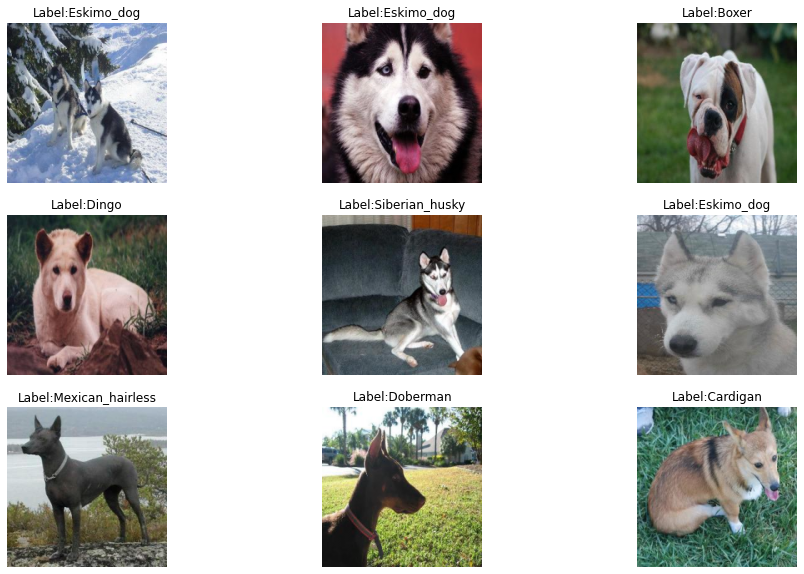

In [ ]:
# A list with the names of the image classes
label_names = ['African_hunting_dog', 'Dhole', 'Dingo', 'Mexican_hairless', 'Standard_poodle', 'Miniature_poodle', 
               'Cardigan', 'Pomeranian', 'Siberian_husky', 'Boxer', 'Doberman', 'Eskimo_dog']

# Plot a few images to check if the labels make sense
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(train_images[i[0]])
    plt.title('Label:' + str(label_names[train_labels[i[0]]]))
    plt.axis('off')

# Part 1 - Train a deep learning model using transfer learning on the Stanford Dog Breed data set.

In [ ]:
train_labels_encoded = tf.keras.utils.to_categorical(train_labels,12)
test_labels_encoded = tf.keras.utils.to_categorical(test_labels,12)
val_labels_encoded = tf.keras.utils.to_categorical(val_labels,12)

# Remember:
# 1. If you use one-hot vectors for the labels, the loss function in the model needs to be 'categorical_crossentropy'
# 2. If you use a single class value for the labels, the loss in the model needs to be 'sparse_categorical_crossentropy'

In [ ]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

## Early Stopping
This code sets up an early stopping callback for a machine learning model using the Keras library in TensorFlow. The purpose of the callback is to monitor the validation loss during the training process and stop the training process if the validation loss does not improve for a certain number of epochs, referred to as PATIENCE.

`monitor`: This parameter specifies the quantity to be monitored during the training process. In this case, the validation loss (`val_loss`) is monitored, meaning the callback will stop the training process if the validation loss does not improve.

`patience`: This parameter determines the number of epochs with no improvement after which the training process will be stopped. The value of PATIENCE determines the number of epochs with no improvement.

`restore_best_weights`: This parameter specifies whether to restore the weights of the model from the epoch with the best validation loss. If True, the weights will be restored, which ensures that the best model is saved.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss',
                   patience = 5,
                   restore_best_weights=False)]

## Creating the model

Now we're going to build our deep learning model to train on our dataset. Here we're going to import necessary layers, optimizers, and model. As we're going to use `ResNet50` as our backbone and pretrained weights of `imagenet` therefore from `tf.keras.applications` we're taking ResNet50 however, to use different models such as `VGG16` replacing the name will work. To know more about the other models visit here "[TensorFlow Applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications/)"

We're adding additional fully connected layer and dropout layer on the top of our base model (ResNet50) to train our model more accuractely. For the activation function `relu` is often used in deep learning model. And as we're going to have 12 class as our output dimention. We're using `softmax` int he last layer to get the prediction probalities of each of the class.

We're using `Adam` as our optimizers however, others such as `SGD` can be tested. To learn more about optimizers visit [Tensoflow Optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/legacy)

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model


#create our model
def build_model():
    #create ResNet50 model with properties we want.
    base_model = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                    weights="imagenet",
                                    input_shape=(224,224,3))


    #create fully connected layers
    #by not including the top we need to create these layers ourselves
    #input and output layers
    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add a fully-connected layer
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    # Add a softmax layer with 12 classes
    predictions = Dense(12, activation='softmax', name ='softmax')(x)

    # The model 
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
    
    return model

## Training the model
Now, we are going to train the model for 100 epochs and see the performance. Our target is to get the testing accuracy over 50%. We can fine-tune our model to get our desired result. 

**Remember**, Stanford dog breeds classification is very difficult as all the dogs have very similar features in their images. That's why with double training times compared to FIGRIM dataset we're targeting the classification accuracy of 50%

In [ ]:
model = build_model()
history = model.fit(train_images, train_labels_encoded, epochs=100, 
                    validation_data=(val_images, val_labels_encoded))

Train on 1254 samples, validate on 314 samples
Epoch 1/100
1254/1254 [==============================] - ETA: 0s - loss: 2.0668 - accuracy: 0.3509

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1254/1254 [==============================] - 33s 26ms/sample - loss: 2.0668 - accuracy: 0.3509 - val_loss: 427.7364 - val_accuracy: 0.0860
Epoch 2/100
1254/1254 [==============================] - 18s 14ms/sample - loss: 1.6243 - accuracy: 0.4522 - val_loss: 226.6782 - val_accuracy: 0.0860
Epoch 3/100
1254/1254 [==============================] - 18s 14ms/sample - loss: 1.3682 - accuracy: 0.5415 - val_loss: 45.2279 - val_accuracy: 0.0796
Epoch 4/100
1254/1254 [==============================] - 18s 14ms/sample - loss: 1.0766 - accuracy: 0.6316 - val_loss: 132.7678 - val_accuracy: 0.1019
Epoch 5/100
1254/1254 [==============================] - 18s 14ms/sample - loss: 0.9712 - accuracy: 0.6651 - val_loss: 2.7998 - val_accuracy: 0.0828
Epoch 6/100
1254/1254 [==============================] - 18s 14ms/sample - loss: 0.8426 - accuracy: 0.6850 - val_loss: 3.2248 - val_accuracy: 0.0955
Epoch 7/100
1254/1254 [==============================] - 18s 14ms/sample - loss: 0.6400 - accuracy: 0.7616 - va

## Saving the model

Training the model can often be very time consuimg. Therefore, it is always the best idea to save the model after training. 

**Note:**
Sometimes adversarial attacks doesn't work well on saved model. So if you're planning to apply adversarial attack it is suggested to apply the attack while the model is still in the memory after training. Save the model after adversarial attack is applied.

In [ ]:
from tensorflow.keras.models import load_model

#save the model
model.save(PROJECT_ROOT_DIR + MODEL_DIR +'ResNet50.h5')

#save our history so we dont lose it.
np.save(PROJECT_ROOT_DIR + MODEL_DIR + "trainResNet50HistoryDict.npy", history.history)

#load our already trained model
model = load_model(PROJECT_ROOT_DIR + MODEL_DIR +'ResNet50.h5')

Instructions for updating:
Colocations handled automatically by placer.


## Plotting the graph

From the plot we can see how our model performed during the training. It's conspicuous that our validation loss had a very rough ride during the training time. From here we can easily understand this dataset is very difficult to train.

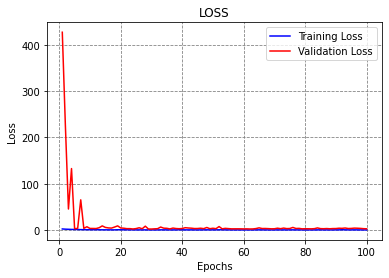

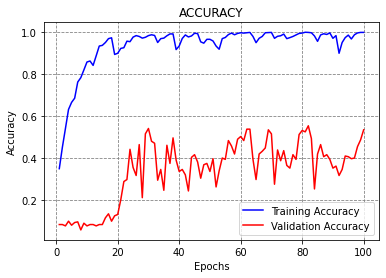

In [ ]:
history = np.load(PROJECT_ROOT_DIR + MODEL_DIR + "trainResNet50HistoryDict.npy",allow_pickle=True).item()


# Plot the loss and accuracy
train_loss = history['loss']
val_loss = history['val_loss']
acc = history['accuracy'] 
val_acc = history['val_accuracy']


epochsn = np.arange(1, len(train_loss)+1,1)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')


axes = plt.gca()

plt.figure()
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()            
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
#Taking an index value
sample_idx = 5
# Saving test images 5 as sample image (index value from test images)
sample_image = test_images[sample_idx]
#Predicting the image
sample_pred = pred_val_max[sample_idx]
#Checking True Labels
sample_true = test_labels[sample_idx]

Text(0.5, 1.0, 'The true class of the image is: Eskimo_dog\nThe predicted class label: Eskimo_dog')

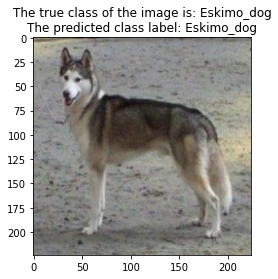

In [ ]:
plt.imshow(sample_image)
plt.title(f"The true class of the image is: {label_names[sample_true]}\nThe predicted class label: {label_names[sample_pred]}")

# Part 2 & 3 Applying PGD Atack for Both Targeted and Untargeted
In this section we're going to apply white-box evasion attack PGD. We're going to apply the attack from a library called **"Adversarial Robustness Toolbox"** often referred as *ART* library.  

In [ ]:
# To Install the ART library where adversarial attacks are given
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 59.3 MB/s eta 0:00:00


Similar to the first model we're importing necessary packages. In order to use the saved model we're still importing packages which are already imported. Therefore, if you're planning not to use saved model, it's not necessary to import the package again.

Keep in mind
```
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
```
These are most important, for classifier we're using KerasClassifier, but you can use any other classifier according to your environment such as "**TensorflowV2Classifier**" or "**PytorchClassifier**". And for the attacks we're importing **ProjectedGradientDescent**(PGD) only

In [ ]:
#perform adversiarial attacks such as Fast gradient and  ProjectedGradientDescent, DeepFool, NewtonFool
from art.estimators.classification import KerasClassifier,TensorFlowV2Classifier
from art.estimators.certification.randomized_smoothing import TensorFlowV2RandomizedSmoothing
from art.estimators import KerasEstimator
from art.attacks.evasion import ProjectedGradientDescent
import sys

def pgd_attack(Epsilon,Classifier,Imgs_Test,Targeted, Labels=None):
    
    attackPgd = ProjectedGradientDescent(estimator = Classifier,
                                         eps=(Epsilon/255),
                                         targeted=Targeted,
                                         batch_size =256)
    
    #check our parameters and perform the proper actions
    #if we have labels and we are targeted we can generate the proper images
    if Targeted == True and Labels is not None:
        return attackPgd.generate(Imgs_Test,Labels)
    
    #We just want to perturbe the image set without any targeting.
    elif Targeted == False:
        return attackPgd.generate(Imgs_Test)
    
    #some form of parameter error
    else:
        print("make sure you have given the function: pgd_attack a set of labels if you are doing targeted attacks")
        print("Stopping program ...")
        sys.exit()

We're given a range of epsilon value which I've saved under `epsilon_list`. At first we're going define the target index for the targeted attack. We've selected `target_idx = 15` but it can be any index based on the user choice. 

As we know different perturbation will produce different results. The code is run under a loop to append all the results. As we're going to test both targeted and untargeted attack. We seperated two list `imgs_adv_pgd` and `targeted_adv_pgd` they're being used to apply the attack.

The difference between targeted and untargeted attack in the code is two parameters. 

`Targeted=False ` means it's not targeted `Targeted=True` means targeted
`Labels = test_labels_encoded[target_idx]` means it's targeted the class. 

In [ ]:
#List for plotting and storing images to display. 

pgd_acc_list = []
pgd_image_list = []
pgd_pred_list = []
pgd_pertb_list = []
target_image_list = []
target_idx = 15
#Given epsilon list from the assignment. 
epsilon_list =  [1/255, 3/255, 5/255, 8/255, 20/255, 50/255, 80/255]

classifier = KerasClassifier(model=model, clip_values=(0, 1))

for eps in epsilon_list:
    #Applying Targeted Attack. Target Index 15
    imgs_adv_pgd = pgd_attack(eps*255,classifier,np.reshape(sample_image,(1,224, 224,3)),Targeted=False,Labels=sample_true)
    #Applying Targeted Attack. Target Index 15
    targeted_adv_pgd = pgd_attack(eps*255,classifier,np.reshape(sample_image,(1,224, 224,3)),True,test_labels_encoded[target_idx])
    
    # Adding the output into the list
    pgd_image_list.append(imgs_adv_pgd[0])
    target_image_list.append(targeted_adv_pgd[0])



Exception ignored in: <function tqdm.__del__ at 0x7f2258ecd310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tqdm/std.py", line 1161, in __del__
    def __del__(self):
KeyboardInterrupt: 


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

## Plotting the adversraially attacked images
Here we can see same images with different noise based on their perturbation.
Our plan is to make the original class label "Siberian_husky" predicted by Clairfai's AI model as different. And the confident should be higher than the actual class.

Clarifai is a company that offers an artificial intelligence platform for image and video recognition. Their platform uses advanced machine learning algorithms to identify and categorize visual content, enabling businesses to develop and deploy custom visual recognition models for a wide range of applications.

The Clarifai platform offers a variety of tools for developers and data scientists, including pre-built models for specific use cases such as object detection, facial recognition, and visual similarity. Additionally, the platform provides an API that enables developers to integrate Clarifai's visual recognition capabilities into their own applications and services.

Clarifai's technology has been used by a variety of industries, including e-commerce, media and entertainment, automotive, and healthcare. Their platform has also been used in academic research and by government agencies for tasks such as satellite image analysis and law enforcement.

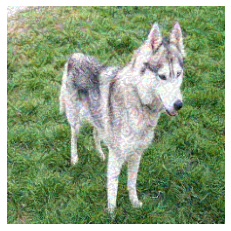

In [ ]:
imgs_adv_pgd.shape
plt.imshow(pgd_image_list[4])
plt.axis('off')
plt.savefig('img1.jpg')

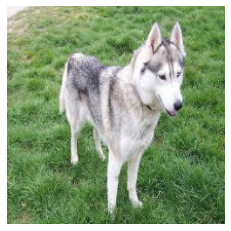

In [ ]:
#This will print our traget class. target_idx value is defined above.
plt.title(f"Targeted to be: {label_names[target_idx]}")
plt.imshow(target_image_list[0])
plt.axis('off')
plt.savefig('img2.jpg')

(-0.5, 223.5, 223.5, -0.5)

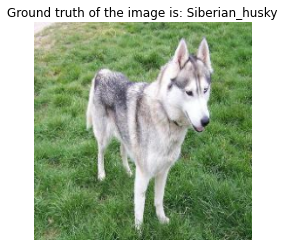

In [ ]:
# our Ground Truth Label of Image
plt.imshow(sample_image)
plt.title(f"Ground truth of the image is: {label_names[sample_true]}")
plt.axis('off')

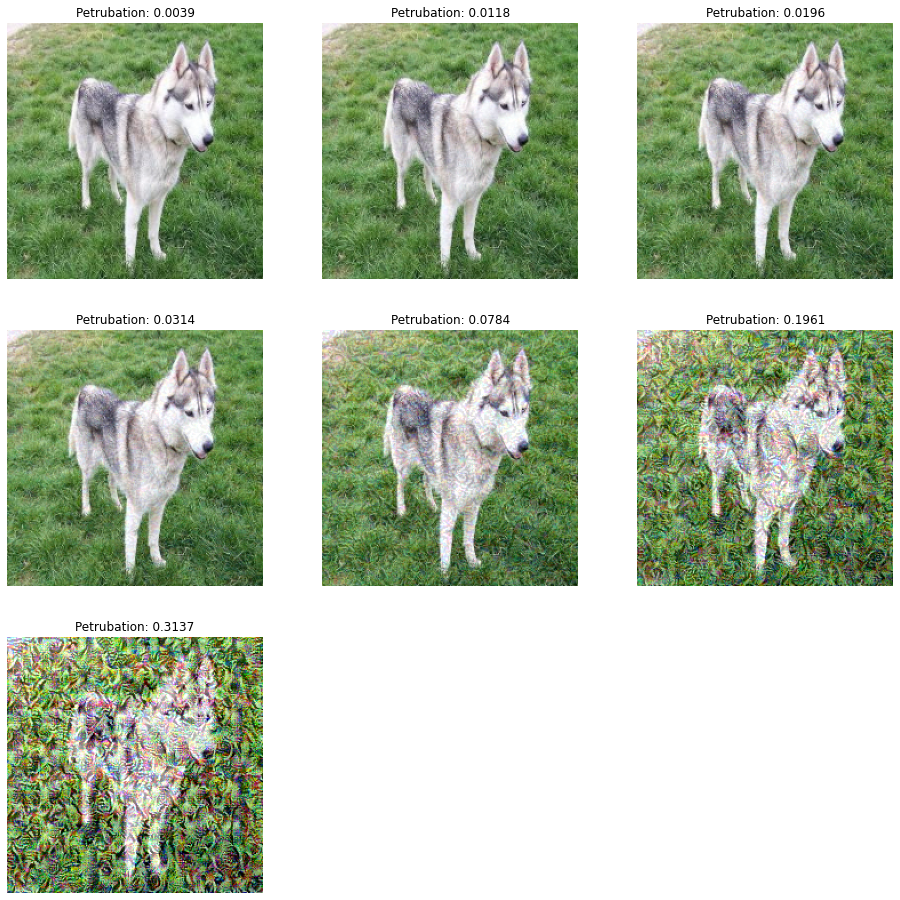

In [ ]:
#Visualizing the images based on their perturbation level.
plt.figure(figsize=(16,16))
for i,img in enumerate(pgd_image_list):
  ax = plt.subplot(3, 3, i+1)
  ax.axis('off')
  plt.imshow(img)
  plt.title(f"Petrubation: {round(epsilon_list[i],4)}")
plt.savefig('AllPerturbedImage.jpg')

# Part 4 - Applying on Clarifai Website
Visit the Clarifai website for predicting dog breeds: https://clarifai.com/datastrategy/dog-breeds/models/dog-breeds-classifier
You will be prompted to sign in, and I think that the easiest way is to sign in with an existing Gmail account or GitHub account. Click on the button “Try your own image or video” to upload the selected image

The output results are given on the summary section. But feel free to try with your own image.

#Summary

Ground truth label and predicted labels are printed above. 

For the adversarial attack I created adversarial samples using PGD with these epsilon values [1/255, 3/255, 5/255, 8/255, 20/255, 50/255, 80/255]. The outcome of pertubed images are shown with their epsilon value above.

I'm adding only 2 targeted attack results here. My motive was to make the Clarifai model predict "Siberian Husky" as "Eskimo Dog". Surprisingly, the model predicts Siberian Husky as Eskimo Dog with lower perturbations. But as the perturbation increases it predicts it as different class. I'm attaching two images here.

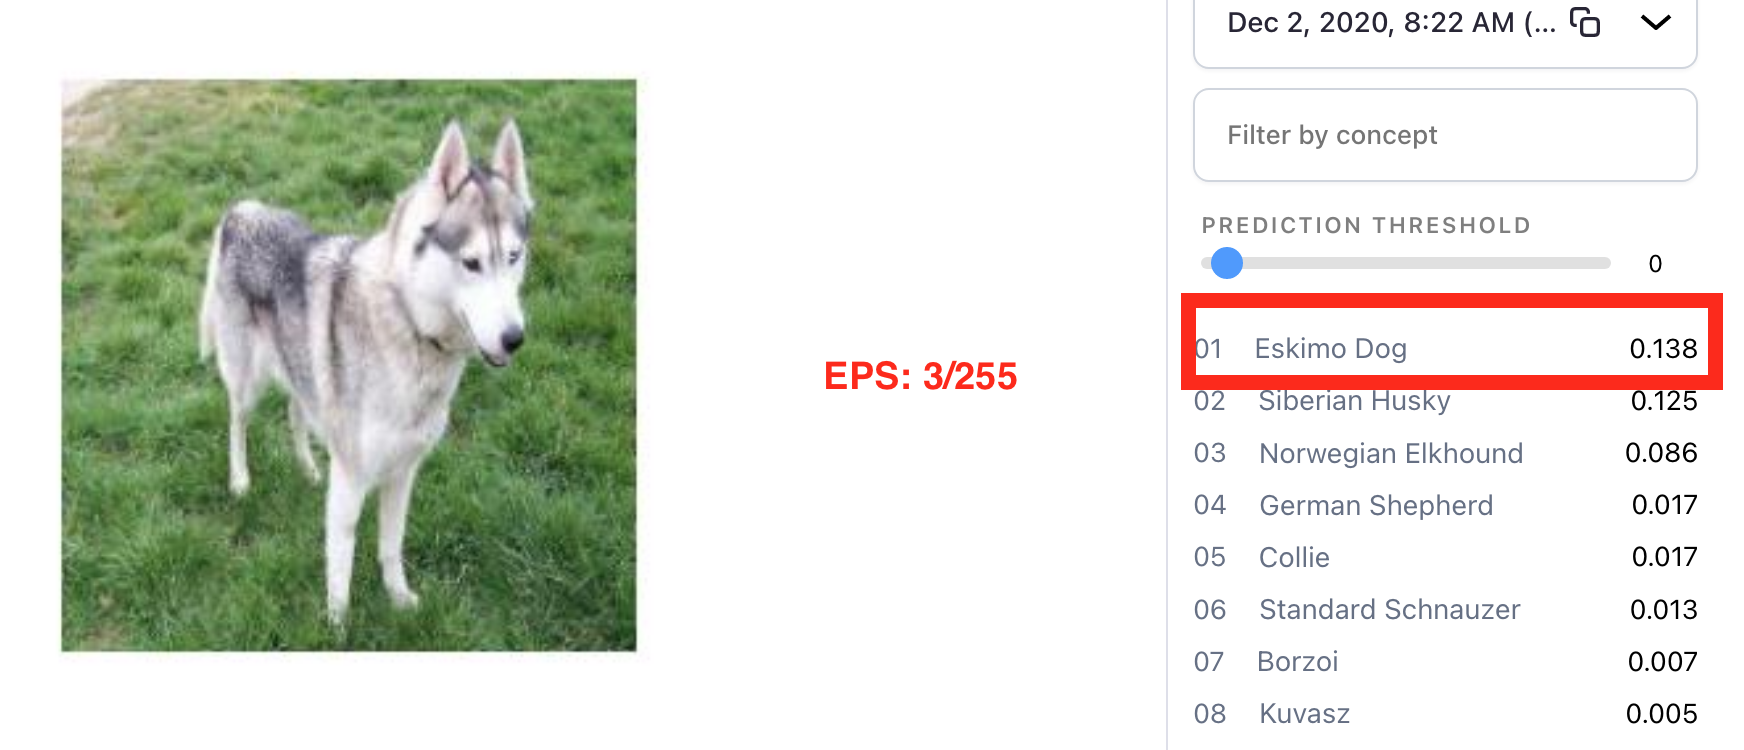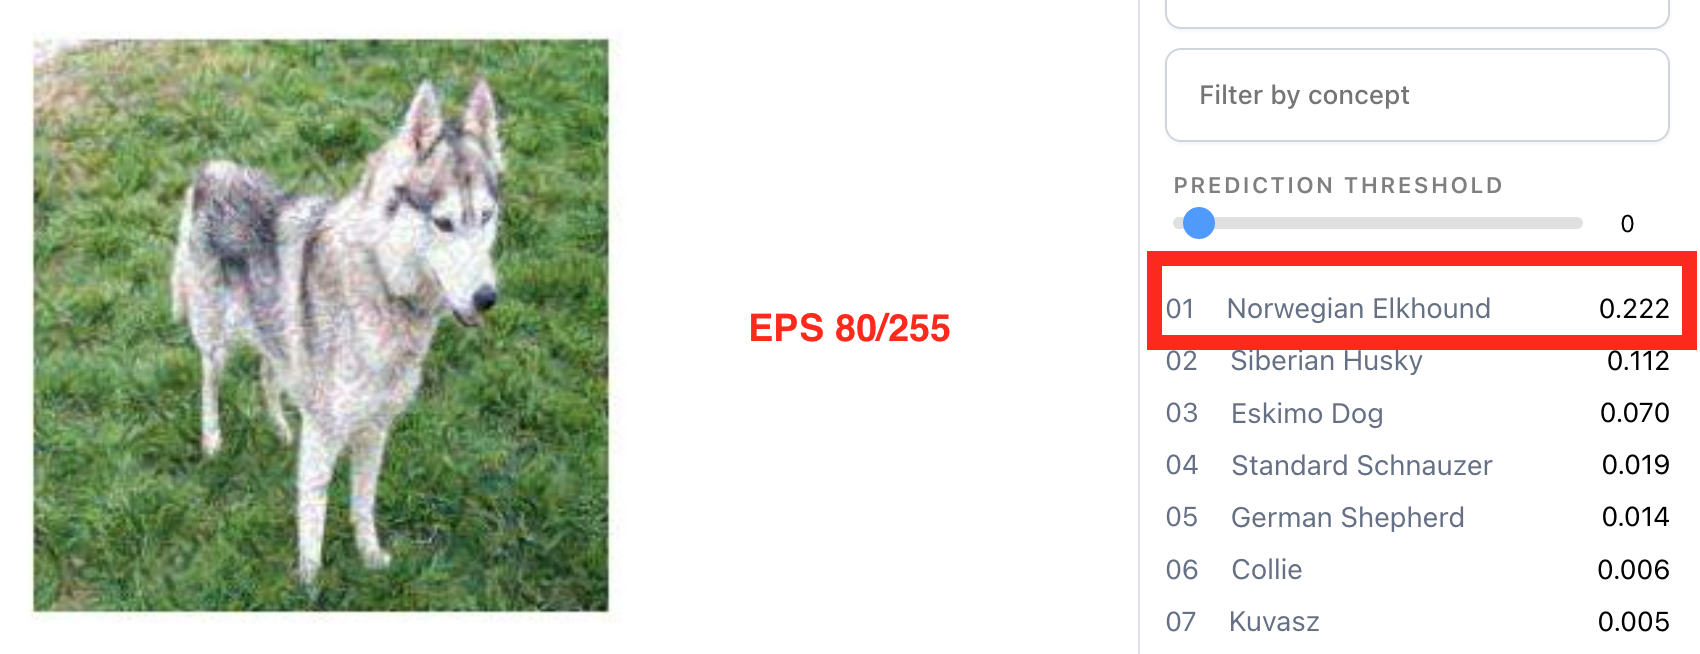